<a href="https://colab.research.google.com/github/ptkoo/2DPlotterFromImage/blob/main/2DPlotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import ndimage
import imageio
from PIL import Image, ImageFilter
import argparse
import cv2
import matplotlib.pyplot as plt
import sys
import constantsB
from google.colab.patches import cv2_imshow


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

# Gray Scale Conversion

(480, 640)


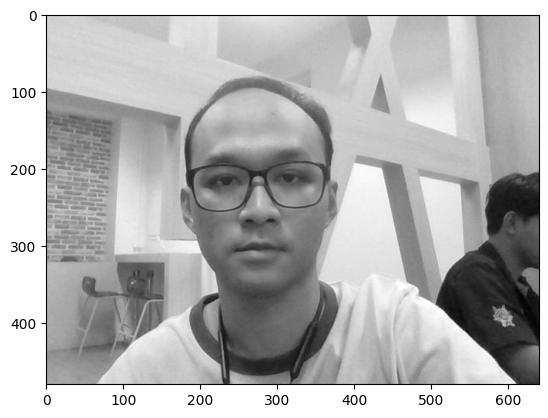

In [ ]:
img = cv2.imread("photo.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
print(gray.shape)

# Face Detection

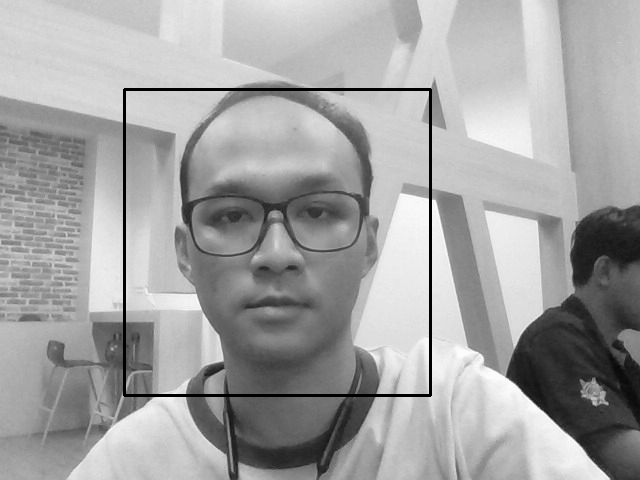

-1

In [ ]:
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor = 1.2,
    minNeighbors = 5,
    minSize = (1,1),
    flags = cv2.CASCADE_SCALE_IMAGE
)
x1 = 0
y1 = 0
enlarged_w = 0
enlarged_h = 0

for (x, y, w, h) in faces:
    # Increase the size of the rectangle
    enlarged_w = int(w * 1.3)  # Scale width by a factor of 1.5
    enlarged_h = int(h * 1.3)  # Scale height by a factor of 1.5
    # Calculate the coordinates for the larger rectangle
    x1 = max(0, x - (enlarged_w - w) // 2)
    y1 = max(0, y - (enlarged_h - h) // 2)
    # Draw the larger rectangle
    cv2.rectangle(gray, (x1, y1), (x1 + enlarged_w, y1 + enlarged_h), (0, 255, 0), 2)


cv2_imshow(gray)
cv2.waitKey(0)

# Cropping

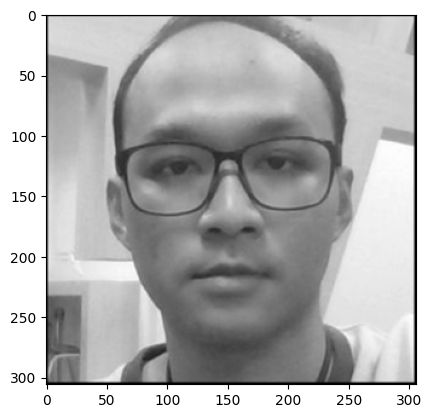

In [ ]:
x = x1
y = y1
w = enlarged_w
h = enlarged_h
gray = cv2.getRectSubPix(gray,(w,h),(x+(w/2),y+(h/2)))
plt.imshow(gray, cmap = 'gray')

#  Histrogram Equalization and CLAHE
- A method of redistributing pixel intensities

**Reason**

- Contrast Enhancement
- Image Enhancement

# How does it work?

* The image is divided into smaller tiles or block
* A histogram is calculated for each tile.
* If any histogram tile is above the specified cliff limit, those excess pixels are clipped and the contrast of that tile is limited
* Then the clipped excess is redistributed uniformly to other bins before applying the historgram equalization
* Apply histogram equilization to each tile.
* The final image is obtained by interpolating the tiles back.

Text(0, 0.5, 'number of pixels')

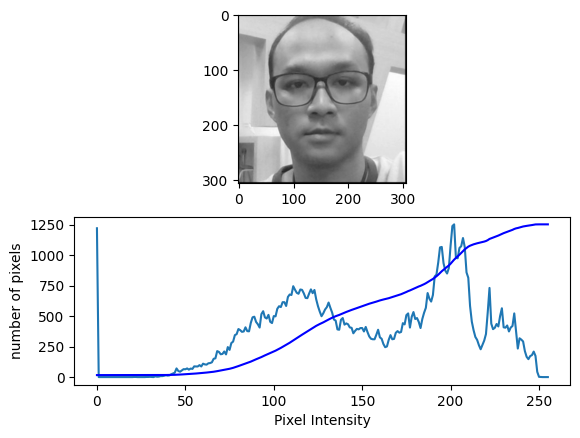

In [ ]:
# Apply Adaptive Histogram Equalization
hist = cv2.calcHist([gray], [0], None, [256], [0,256])
# CDF
cdf = hist.cumsum()
# Normalization ( cdf * scaling factor)
cdfNorm = cdf * float(hist.max())/cdf.max()

plt.figure()
plt.subplot(211)
plt.imshow(gray, cmap='gray')
plt.subplot(212)
plt.plot(hist)
plt.plot(cdfNorm, color='b')
plt.xlabel('Pixel Intensity')
plt.ylabel('number of pixels')

# Equalization

Text(0, 0.5, 'number of pixels')

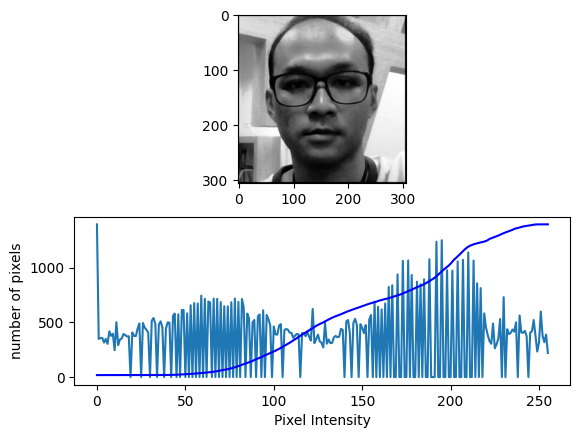

In [ ]:
equimg = cv2.equalizeHist(gray)
equhist = cv2.calcHist([equimg], [0], None, [256], [0,256])
# CDF
equcdf = equhist.cumsum()
# Normalization ( cdf * scaling factor)
equcdfNorm = cdf * float(equhist.max())/equcdf.max()
plt.subplot(211)
plt.imshow(equimg, cmap='gray')
plt.subplot(212)
plt.plot(equhist)
plt.plot(equcdfNorm, color='b')
plt.xlabel('Pixel Intensity')
plt.ylabel('number of pixels')

# Clahe Method : To make the smaller region more dominant

Text(0, 0.5, 'number of pixels')

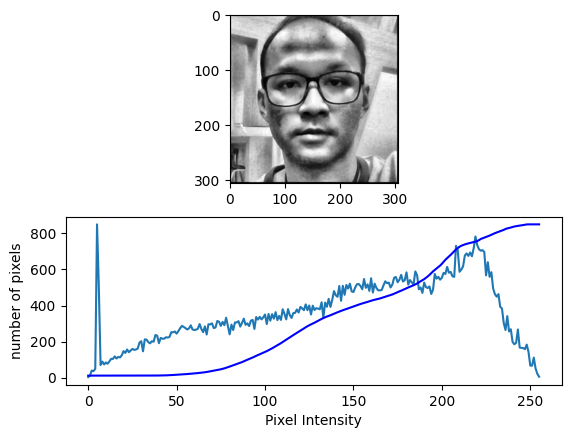

In [ ]:
claheObject = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
claheImg = claheObject.apply(gray)
clahehist = cv2.calcHist([claheImg], [0], None, [256], [0,256])
# CDF
clahecdf = clahehist.cumsum()
# Normalization ( cdf * scaling factor)
clahecdfNorm = cdf * float(clahehist.max())/clahecdf.max()
plt.figure()
plt.subplot(211)
plt.imshow(claheImg, cmap='gray')
plt.subplot(212)
plt.plot(clahehist)
plt.plot(clahecdfNorm, color='b')
plt.xlabel('Pixel Intensity')
plt.ylabel('number of pixels')

# Apply Gaussian blur to reduce noise and make edges smoother.


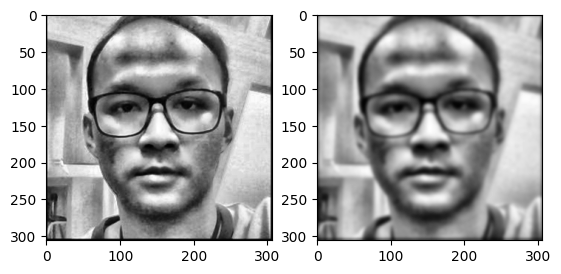

In [ ]:
# Gaussian Filter
ksize = 15
sigma = 2 # 0.5 lower value to smooth things
gX = cv2.getGaussianKernel( ksize, sigma)
gY = np.transpose(gX)
# print (gX)
# print(gY)
gKernel = gX * gY
# print ( gKernel)


guassianBlurImg = cv2.filter2D(claheImg, 0, gKernel)
plt.subplot(1,2,1)
plt.imshow(claheImg, cmap= 'gray')
plt.subplot ( 1,2,2)
plt.imshow(guassianBlurImg, cmap= 'gray')

# Laplacian Edge Detection

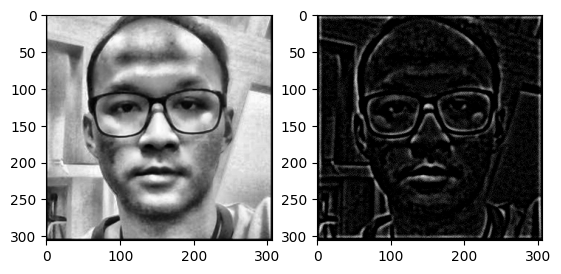

In [ ]:
# Laplacian edge detection

LKernel = np.float32([[0, -1, 0],
                    [-1,4,-1],
                    [0, -1, 0]])

lap_res = cv2.filter2D(guassianBlurImg, 0, LKernel)
plt.subplot(1,2,1)
plt.imshow(claheImg, cmap= 'gray')
plt.subplot(1,2,2)
plt.imshow(lap_res, cmap = 'gray')

# Prewit Edge Detection

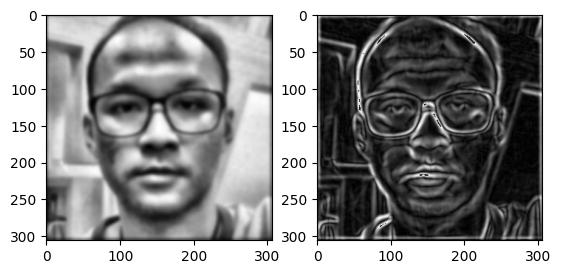

In [ ]:
# Prewitt edge detection

kernelX = np.float32([[1, 0, -1],
                     [1, 0, -1],
                     [1, 0, -1]])

kernelY = kernelX.T

# print(kernelX,'\n\n', kernelY)

Gx = cv2.filter2D(guassianBlurImg, cv2.CV_16S, kernelX)
Gy = cv2.filter2D(guassianBlurImg, cv2.CV_16S, kernelY)

GxA = cv2.convertScaleAbs(Gx)
GyA = cv2.convertScaleAbs(Gy)

resPrewitt = GxA + GyA

plt.subplot(1,2,1); plt.imshow(guassianBlurImg, cmap = 'gray')
plt.subplot(1,2,2); plt.imshow(resPrewitt, cmap = 'gray')

# Sobel Edge Detection

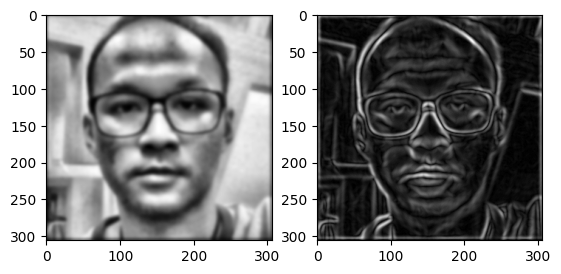

In [ ]:
# Sobel edge detection

Gx = cv2.Sobel(guassianBlurImg, cv2.CV_16S, 1, 0, ksize = 1)
Gy = cv2.Sobel(guassianBlurImg, cv2.CV_16S, 0, 1, ksize = 1)

GxA = cv2.convertScaleAbs(Gx)
GyA = cv2.convertScaleAbs(Gy)


resSobel = GxA + GyA

plt.subplot(1,2,1); plt.imshow(guassianBlurImg, cmap = 'gray')
plt.subplot(1,2,2); plt.imshow(resSobel, cmap = 'gray')

# Canny Edge Detection

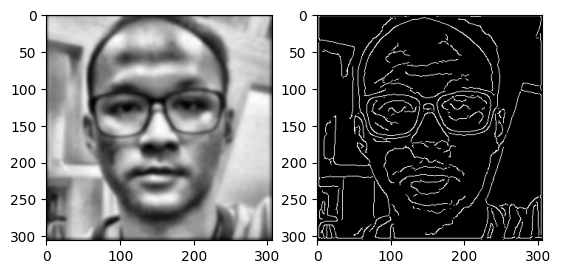

In [ ]:
#Canny

resCanny = cv2.Canny(guassianBlurImg,1,100)
plt.subplot(1,2,1); plt.imshow(guassianBlurImg, cmap = 'gray')
plt.subplot(1,2,2); plt.imshow(resCanny, cmap = 'gray')


# Image Post Processing

# Laplacian

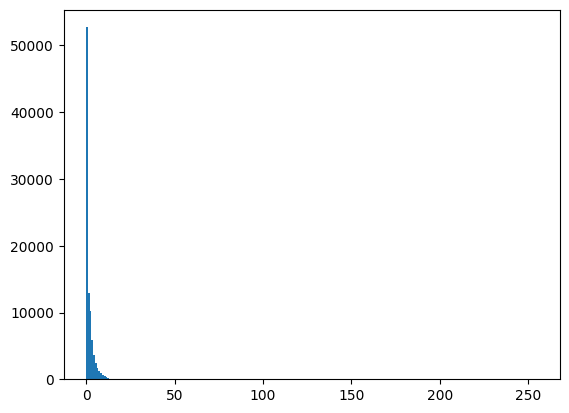

In [ ]:
#plot histogram

plt.hist(lap_res.ravel(),256,(0,255))
plt.show()

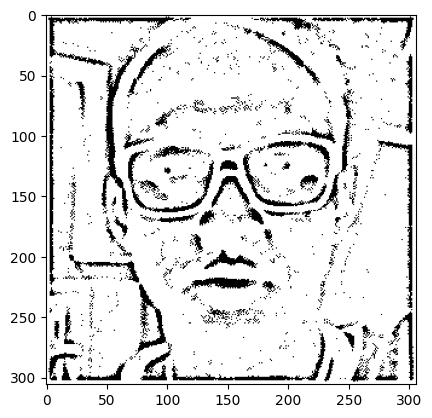

In [ ]:
threshold_value = 3

ret, bwLap = cv2.threshold(lap_res,threshold_value,255,cv2.THRESH_BINARY_INV)   #less than threshold is white, the rest black
plt.imshow(bwLap,cmap ='gray')

# Canny

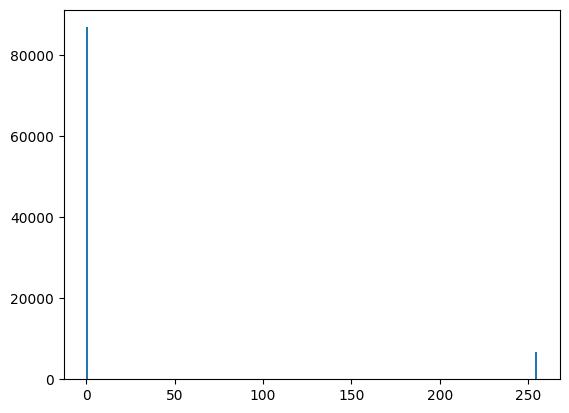

In [ ]:
#plot histogram

plt.hist(resCanny.ravel(),256,(0,255))
plt.show()

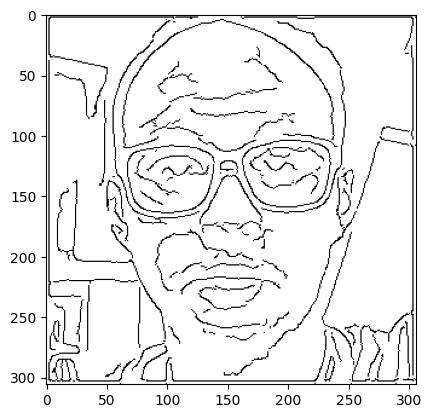

In [ ]:
threshold_value = 2

ret, bwCanny = cv2.threshold(resCanny,threshold_value,255,cv2.THRESH_BINARY_INV)   #less than threshold is white, the rest black
plt.imshow(bwCanny,cmap ='gray')

# Prewitt


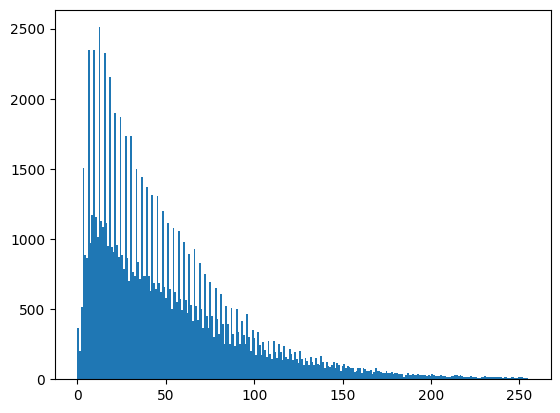

In [ ]:
#plot histogram

plt.hist(resPrewitt.ravel(),256,(0,255))
plt.show()

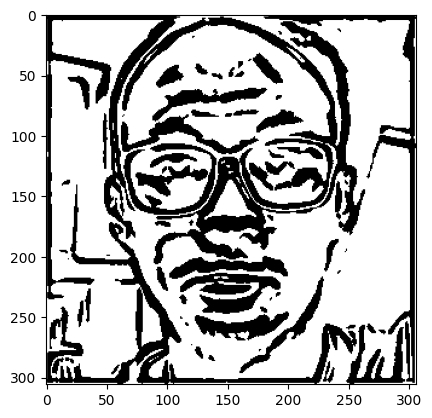

In [ ]:
threshold_value = 60

ret, bwPrewitt = cv2.threshold(resPrewitt,threshold_value,255,cv2.THRESH_BINARY_INV)   #less than threshold is white, the rest black
plt.imshow(bwPrewitt,cmap ='gray')

# Sobel

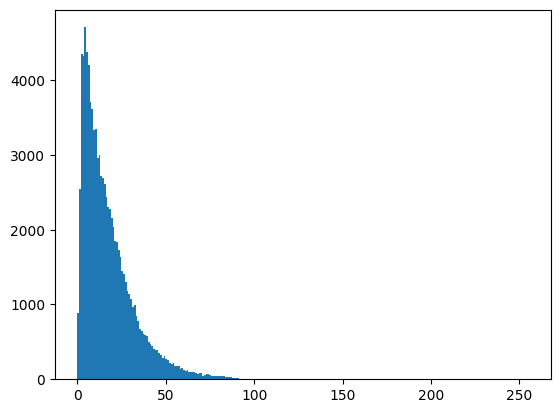

In [ ]:
#plot histogram

plt.hist(resSobel.ravel(),256,(0,255))
plt.show()

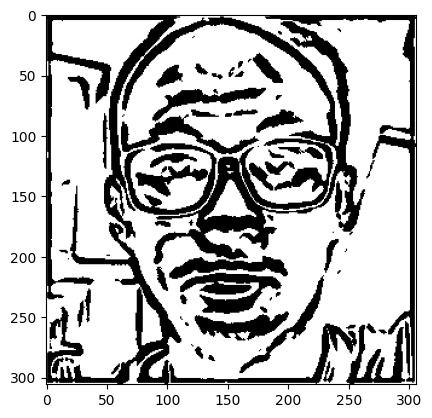

In [ ]:
threshold_value = 20

ret, bwSobel = cv2.threshold(resSobel,threshold_value,255,cv2.THRESH_BINARY_INV)   #less than threshold is white, the rest black
plt.imshow(bwSobel,cmap ='gray')

# Gcode converter

In [ ]:
class CircularRange:
	def __init__(self, begin, end, value):
		self.begin, self.end, self.value = begin, end, value

	def __repr__(self):
		return f"[{self.begin},{self.end})->{self.value}"

	def halfway(self):
		return int((self.begin + self.end) / 2)

class Graph:
	class Node:
		def __init__(self, point, index):
			self.x, self.y = point
			self.index = index
			self.connections = {}

		def __repr__(self):
			return f"({self.y},{-self.x})"

		def _addConnection(self, to):
			self.connections[to] = False # i.e. not already used in gcode generation

		def toDotFormat(self):
			return (f"{self.index} [pos=\"{self.y},{-self.x}!\", label=\"{self.index}\\n{self.x},{self.y}\"]\n" +
				"".join(f"{self.index}--{conn}\n" for conn in self.connections if self.index < conn))


	def __init__(self):
		self.nodes = []

	def __getitem__(self, index):
		return self.nodes[index]

	def __repr__(self):
		return repr(self.nodes)


	def addNode(self, point):
		index = len(self.nodes)
		self.nodes.append(Graph.Node(point, index))
		return index

	def addConnection(self, a, b):
		self.nodes[a]._addConnection(b)
		self.nodes[b]._addConnection(a)

	def distance(self, a, b):
		return np.hypot(self[a].x-self[b].x, self[a].y-self[b].y)

	def areConnectedWithin(self, a, b, maxDistance):
		if maxDistance < 0:
			return False
		elif a == b:
			return True
		else:
			for conn in self[a].connections:
				if self.areConnectedWithin(conn, b, maxDistance - self.distance(conn, b)):
					return True
			return False

	def saveAsDotFile(self, f):
		f.write("graph G {\nnode [shape=plaintext];\n")
		for node in self.nodes:
			f.write(node.toDotFormat())
		f.write("}\n")

	def saveAsGcodeFile(self, f):
		### First follow all paths that have a start/end node (i.e. are not cycles)
		# The next chosen starting node is the closest to the current position

		def pathGcode(i, insidePath):
			f.write(f"G{1 if insidePath else 0} X{self[i].y/2} Y{-self[i].x/2}\n")
			for connTo, alreadyUsed in self[i].connections.items():
				if not alreadyUsed:
					self[i].connections[connTo] = True
					self[connTo].connections[i] = True

					return pathGcode(connTo, True)
			return i

		possibleStartingNodes = set()
		for i in range(len(self.nodes)):
			if len(self[i].connections) == 0 or len(self[i].connections) % 2 == 1:
				possibleStartingNodes.add(i)

		if len(possibleStartingNodes) != 0:
			node = next(iter(possibleStartingNodes)) # first element
			while 1:
				possibleStartingNodes.remove(node)
				pathEndNode = pathGcode(node, False)

				if len(self[node].connections) == 0:
					assert pathEndNode == node

					f.write(f"G1 X{-self[node].y/2} Y{-self[node].x/2}\n")

				else:
					possibleStartingNodes.remove(pathEndNode)

				if len(possibleStartingNodes) == 0:
					break

				minDistanceSoFar = np.inf
				for nextNode in possibleStartingNodes:
					distance = self.distance(pathEndNode, nextNode)
					if distance < minDistanceSoFar:
						minDistanceSoFar = distance
						node = nextNode


		### Then pick the node closest to the current position that still has unused/available connections
		# That node must belong to a cycle, because otherwise it would have been used above
		# TODO improve by finding Eulerian cycles

		cycleNodes = set()
		for i in range(len(self.nodes)):
			someConnectionsAvailable = False
			for _, alreadyUsed in self[i].connections.items():
				if not alreadyUsed:
					someConnectionsAvailable = True
					break

			if someConnectionsAvailable:
				cycleNodes.add(i)

		def cyclePathGcode(i, insidePath):

			f.write(f"G{1 if insidePath else 0} X{self[i].y/2} Y{-self[i].x/2}\n")
			foundConnections = 0
			for connTo, alreadyUsed in self[i].connections.items():
				if not alreadyUsed:
					if foundConnections == 0:
						self[i].connections[connTo] = True
						self[connTo].connections[i] = True
						cyclePathGcode(connTo, True)

					foundConnections += 1
					if foundConnections > 1:
						break

			if foundConnections == 1:
				cycleNodes.remove(i)

		if len(cycleNodes) != 0:
			node = next(iter(cycleNodes)) # first element
			while 1:
				# since every node has an even number of connections, ANY path starting from it
				# must complete at the same place (see Eulerian paths/cycles properties)
				cyclePathGcode(node, False)

				if len(cycleNodes) == 0:
					break

				pathEndNode = node
				minDistanceSoFar = np.inf
				for nextNode in possibleStartingNodes:
					distance = self.distance(pathEndNode, nextNode)
					if distance < minDistanceSoFar:
						minDistanceSoFar = distance
						node = nextNode

In [ ]:
class EdgesToGcode:
	def __init__(self, edges):
		self.edges = edges
		self.ownerNode = np.full(np.shape(edges), -1, dtype=int)
		self.xSize, self.ySize = np.shape(edges)
		self.graph = Graph()

	def getCircularArray(self, center, r, smallerArray = None):
		circumferenceSize = len(constantsB.circumferences[r])
		circularArray = np.zeros(circumferenceSize, dtype=bool)

		if smallerArray is None:
			smallerArray = np.ones(1, dtype=bool)
		smallerSize = np.shape(smallerArray)[0]
		smallerToCurrentRatio = smallerSize / circumferenceSize

		for i in range(circumferenceSize):
			x = center[0] + constantsB.circumferences[r][i][0]
			y = center[1] + constantsB.circumferences[r][i][1]

			if x not in range(self.xSize) or y not in range(self.ySize):
				circularArray[i] = False # consider pixels outside of the image as not-edges
			else:
				iSmaller = i * smallerToCurrentRatio
				a, b = int(np.floor(iSmaller)), int(np.ceil(iSmaller))

				if smallerArray[a] == False and (b not in range(smallerSize) or smallerArray[b] == False):
					circularArray[i] = False # do not take into consideration not connected regions (roughly)
				else:
					circularArray[i] = self.edges[x, y]

		return circularArray

	def toCircularRanges(self, circularArray):
		ranges = []
		circumferenceSize = np.shape(circularArray)[0]

		lastValue, lastValueIndex = circularArray[0], 0
		for i in range(1, circumferenceSize):
			if circularArray[i] != lastValue:
				ranges.append(CircularRange(lastValueIndex, i, lastValue))
				lastValue, lastValueIndex = circularArray[i], i

		ranges.append(CircularRange(lastValueIndex, circumferenceSize, lastValue))
		if len(ranges) > 1 and ranges[-1].value == ranges[0].value:
			ranges[0].begin = ranges[-1].begin - circumferenceSize
			ranges.pop() # the last range is now contained in the first one
		return ranges

	def getNextPoints(self, point):
		"""
		Returns the radius of the circle used to identify the points and
		the points toward which propagate, in a tuple `(radius, [point0, point1, ...])`
		"""

		bestRadius = 0
		circularArray = self.getCircularArray(point, 0)
		allRanges = [self.toCircularRanges(circularArray)]
		for radius in range(1, len(constantsB.circumferences)):
			circularArray = self.getCircularArray(point, radius, circularArray)
			allRanges.append(self.toCircularRanges(circularArray))
			if len(allRanges[radius]) > len(allRanges[bestRadius]):
				bestRadius = radius
			if len(allRanges[bestRadius]) >= 4 and len(allRanges[-2]) >= len(allRanges[-1]):
				# two consecutive circular arrays with the same or decreasing number>=4 of ranges
				break
			elif len(allRanges[radius]) == 2 and radius > 1:
				edge = 0 if allRanges[radius][0].value == True else 1
				if allRanges[radius][edge].end-allRanges[radius][edge].begin < len(constantsB.circumferences[radius]) / 4:
					# only two ranges but the edge range is small (1/4 of the circumference)
					if bestRadius == 1:
						bestRadius = 2
					break
			elif len(allRanges[radius]) == 1 and allRanges[radius][0].value == False:
				# this is a point-shaped edge not sorrounded by any edges
				break

		if bestRadius == 0:
			return 0, []

		circularRanges = allRanges[bestRadius]
		points = []
		for circularRange in circularRanges:
			if circularRange.value == True:
				circumferenceIndex = circularRange.halfway()
				x = point[0] + constantsB.circumferences[bestRadius][circumferenceIndex][0]
				y = point[1] + constantsB.circumferences[bestRadius][circumferenceIndex][1]

				if x in range(self.xSize) and y in range(self.ySize) and self.ownerNode[x, y] == -1:
					points.append((x,y))

		return bestRadius, points

	def propagate(self, point, currentNodeIndex):
		radius, nextPoints = self.getNextPoints(point)

		# depth first search to set the owner of all reachable connected pixels
		# without an owner and find connected nodes
		allConnectedNodes = set()
		def setSeenDFS(x, y):
			if (x in range(self.xSize) and y in range(self.ySize)
					and np.hypot(x-point[0], y-point[1]) <= radius + 0.5
					and self.edges[x, y] == True and self.ownerNode[x, y] != currentNodeIndex):
				if self.ownerNode[x, y] != -1:
					allConnectedNodes.add(self.ownerNode[x, y])
				self.ownerNode[x, y] = currentNodeIndex # index of just added node
				setSeenDFS(x+1, y)
				setSeenDFS(x-1, y)
				setSeenDFS(x, y+1)
				setSeenDFS(x, y-1)

		self.ownerNode[point] = -1 # reset to allow DFS to start
		setSeenDFS(*point)
		for nodeIndex in allConnectedNodes:
			if not self.graph.areConnectedWithin(currentNodeIndex, nodeIndex, 11):
				self.graph.addConnection(currentNodeIndex, nodeIndex)

		validNextPoints = []
		for nextPoint in nextPoints:
			if self.ownerNode[nextPoint] == currentNodeIndex:
				# only if this point belongs to the current node after the DFS,
				# which means it is reachable and connected
				validNextPoints.append(nextPoint)

		for nextPoint in validNextPoints:
			nodeIndex = self.graph.addNode(nextPoint)
			self.graph.addConnection(currentNodeIndex, nodeIndex)
			self.propagate(nextPoint, nodeIndex)
			self.ownerNode[point] = currentNodeIndex

	def addNodeAndPropagate(self, point):
		nodeIndex = self.graph.addNode(point)
		self.propagate(point, nodeIndex)

	def buildGraph(self):
		for point in np.ndindex(np.shape(self.edges)):
			if self.edges[point] == True and self.ownerNode[point] == -1:
				radius, nextPoints = self.getNextPoints(point)
				if radius == 0:
					self.addNodeAndPropagate(point)
				else:
					for nextPoint in nextPoints:
						if self.ownerNode[nextPoint] == -1:
							self.addNodeAndPropagate(nextPoint)

		return self.graph

In [ ]:
def sobel(image):
	image = np.array(image, dtype=float)
	image /= 255.0
	Gx = ndimage.sobel(image, axis=0)
	Gy = ndimage.sobel(image, axis=1)
	res = np.hypot(Gx, Gy)
	res /= np.max(res)
	res = np.array(res * 255, dtype=np.uint8)
	return res[2:-2, 2:-2]

In [ ]:
def convertToBinaryEdges(edges, threshold):
    # Convert grayscale to multi-channel if needed
    if edges.ndim == 2:
        edges = np.stack((edges,) * 3, axis=-1)

    # Compute the maximum across the three channels
    max_values = np.maximum.reduce([edges[:, :, 0], edges[:, :, 1], edges[:, :, 2]])

    # Threshold the maximum values
    result = max_values >= threshold

    # If there are additional channels, consider them in thresholding
    if edges.shape[2] > 3:
        result[edges[:, :, 3] < threshold] = False

    return result

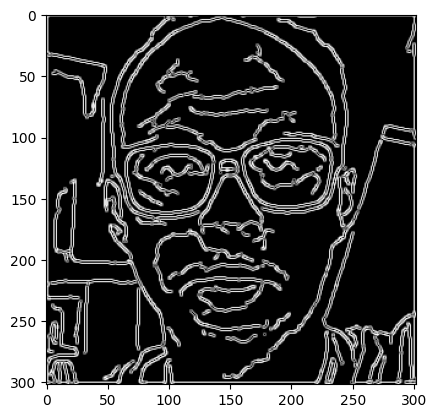

In [ ]:
edges = sobel(bwCanny)
plt.imshow(edges, cmap = 'gray')

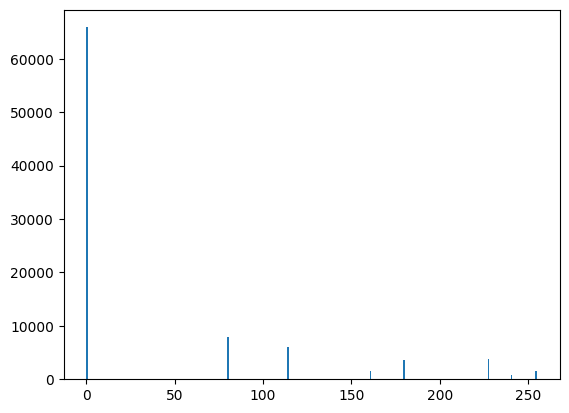

In [ ]:
#plot histogram

plt.hist(edges.ravel(),256,(0,255))
plt.show()

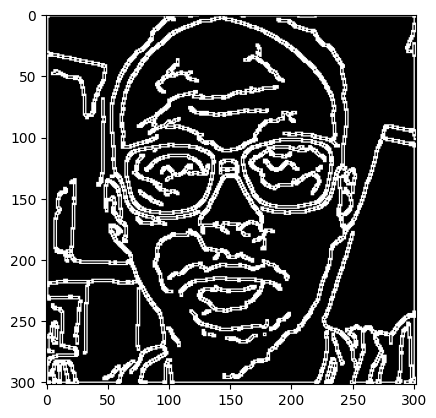

In [ ]:
edges = convertToBinaryEdges(edges, 35)
plt.imshow(edges, cmap = 'gray')


In [1]:
converter = EdgesToGcode(edges)

NameError: name 'EdgesToGcode' is not defined

In [ ]:
converter.buildGraph()


[(2,-1), (4,-1), (5,-1), (6,-1), (7,-1), (8,-1), (9,-1), (10,-1), (11,-1), (12,-1), (13,-1), (14,-1), (15,-1), (16,-1), (17,-1), (18,-1), (19,-1), (20,-1), (21,-1), (22,-1), (23,-1), (24,-1), (25,-1), (26,-1), (27,-1), (28,-1), (29,-1), (30,-1), (31,-1), (32,-1), (33,-1), (34,-1), (35,-1), (36,-1), (37,-1), (38,-1), (39,-1), (40,-1), (41,-1), (42,-1), (43,-1), (44,-1), (45,-1), (46,-1), (47,-1), (48,-1), (49,-1), (50,-1), (51,-1), (52,-1), (53,-1), (54,-1), (55,-1), (56,-1), (57,-1), (58,-1), (59,-1), (60,-1), (61,-1), (62,-1), (63,-1), (64,-1), (65,-1), (66,-1), (67,-1), (68,-1), (69,-1), (70,-1), (71,-1), (72,-1), (73,-1), (74,-1), (75,-1), (76,-1), (77,-1), (78,-1), (79,-1), (80,-1), (81,-1), (82,-1), (83,-1), (84,-1), (85,-1), (86,-1), (87,-1), (88,-1), (89,-1), (90,-1), (91,-1), (92,-1), (93,-1), (94,-1), (95,-1), (96,-3), (97,-5), (99,-3), (103,-2), (105,0), (107,-1), (108,-1), (109,-1), (110,-1), (111,-1), (112,-1), (113,-1), (114,-1), (115,-1), (116,-1), (118,-1), (120,-1), (12

In [ ]:
# Create the file graph.nc
with open('graph.nc', 'w') as f:
  converter.graph.saveAsGcodeFile(f)

KeyboardInterrupt: 

# Modify Gcode

In [ ]:
def remove_duplicate_lines(input_file, output_file):
    # Open the input file in read mode
    with open(input_file, 'r') as f:
        # Read all lines from the file
        lines = f.readlines()

   # Use a list to store unique lines
    unique_lines = []

    # Initialize previous coordinates
    prev_x = 999999
    prev_y = 999999

    # Iterate through each line
    for line in lines:
        # Remove leading and trailing whitespace
        line = line.strip()

        # Split the line into G-code command and coordinates
        command, coordinates = line.split(' ', 1)
        # Extract X and Y values
        x_value = float(coordinates.split(' ')[0][1:])
        y_value = float(coordinates.split(' ')[1][1:])

        # Compare with the previous coordinates
        if x_value != prev_x and y_value != prev_y and x_value != -prev_x and y_value != -prev_y:
            # print(x_value,y_value)
            unique_lines.append(line)
            # Update previous coordinates
            prev_x = x_value
            prev_y = y_value

    # Use a list to store modified lines

    modified_lines = []

    # Iterate through each line
    for i, line in enumerate(unique_lines):
        # Add the line to the modified lines
        modified_lines.append(line)
        # Check if the line contains G0 command
        if line.startswith('G0'):
            # Check if the next line is G1 command
            if i + 1 < len(unique_lines) and unique_lines[i + 1].startswith('G1'):
                # print("I was here!")
                modified_lines.append('M5')
        if line.startswith('G1'):
            # Check if the next line is G1 command
            if i + 1 < len(unique_lines) and unique_lines[i + 1].startswith('G0'):
                # print("I was here!")
                modified_lines.append('M3 S30')
    # Open the output file in write mode
    with open(output_file, 'w') as f:
        # Write unique lines back to the output file
        for line in modified_lines:
            f.write(line + '\n')

# Example usage:
input_file = './graph.nc'
output_file = './modifiedGraph.nc'
remove_duplicate_lines(input_file, output_file)
print("Duplicates removed successfully.")


Duplicates removed successfully.
